In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/My Drive/Face_Recognition"

/content/gdrive/My Drive/Face_Recognition


In [ ]:
############################ 
#Coded by Gan Kian Yu 
############################

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.optim import lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import copy

In [ ]:
print(torch.__version__) #import when we need to load model

1.12.1+cu113


# Class FaceDataset

In [ ]:
class FaceDataset(Dataset):

    def __init__(self, root, transform=None):
        self.data = [] #'name0_0001.jpg', 'name0_0002.jpg', ... #save path but not image, save memory
        self.label = [] #0, 1, 2 ... 
        self.classes = os.listdir(root) #get the list fo classes in the directory ['name0', 'name1', ...]
        self.transform = transform

        #get the list of all files in the dataset (load file name)
        for l, c in enumerate(self.classes): #'name0', 'name1' ...
            cls_folder = os.path.join(root, c)
            for f in os.listdir(cls_folder): #'name0_0001.jpg', 'name0_0002.jpg', ...
                self.data.append(os.path.join(cls_folder, f))
                self.label.append(l)
        self.np_label = np.array(self.label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """return 2 images, 1 label for each batch"""
        #get indexs range that having same class with anchor image
        same_c_idx = np.where(self.np_label == self.label[idx])[0]
        min_same_c_idx = np.min(same_c_idx)
        max_same_c_idx = np.max(same_c_idx)

        
        rand_num = random.randint(0, 1)
        if rand_num == 1: #take sample from other class
            #random generate index for sample in same class 
            idx2 = random.randint(min_same_c_idx, max_same_c_idx)
            while(idx == idx2): #while index positive is equal to anchor index, random again
                idx2 = random.randint(min_same_c_idx, max_same_c_idx)
        else: #take sample from same class
            #random generate index for sample in different class
            length = len(self.data)
            idx2 = random.randint(0, length-1)
            while(min_same_c_idx <= idx2 and idx2 <= max_same_c_idx): #while index generated is same class with anchor image
                idx2 = random.randint(0, length-1)

        # get the image 1 
        img_path = self.data[idx]
        image = Image.open(img_path) #PIL image
        # get the image 2 
        img_path = self.data[idx2]
        image2 = Image.open(img_path) #PIL image

        # perform transformation
        if self.transform is not None:
            image = self.transform(image)
            image2 = self.transform(image2)
        
        # get the label
        label_class = self.label[idx]
        label_class2 = self.label[idx2]
        label = int(label_class == label_class2) #1-same person, 0-not same person
        
        return image, image2, label

---
# Transformation and Data Loader

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transformer
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
batch_size=2

trainset = FaceDataset("./dataset/train", transform=train_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valset = FaceDataset("./dataset/valid", transform=val_transform) #should validation set included random crop/flip transformation?
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)

label: [1, 1, 0, 1, 1, 0, 0, 1, 1, 1]


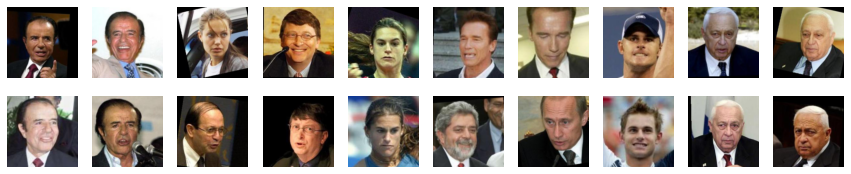

In [ ]:
"""check image loaded"""
img_list = []
img2_list = []
label_list = []
for i in range(0, 200, 20):
    img, img2, label = trainset[i]
    img = img.permute(1, 2, 0)*0.5+0.5
    img2 = img2.permute(1, 2, 0)*0.5+0.5
    img_list.append(img)
    img2_list.append(img2)
    label_list.append(label)

fig = plt.figure(figsize=(15, 3))
columns = 10
rows = 2

for i in range(1, columns +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    plt.axis("off")
    fig.add_subplot(rows, columns, i+10)
    plt.imshow(img2_list[i-1])
    plt.axis("off")

print("label:", label_list)

---
# Load feature extractor (ResNet-34)

In [ ]:
def loadBackBone():
    resNet = torch.load("saved_best_resNet34.pt")
    for name, param in resNet.named_parameters():
        param.requires_grad = False
            
    return resNet

In [ ]:
resNet = loadBackBone()

In [ ]:
print(resNet.fc) #check output feature of backbone network

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
)


In [ ]:
for name, param in resNet.named_parameters(): #check freezed layers
    print(name, "==>", param.requires_grad)

conv1.weight ==> False
bn1.weight ==> False
bn1.bias ==> False
layer1.0.conv1.weight ==> False
layer1.0.bn1.weight ==> False
layer1.0.bn1.bias ==> False
layer1.0.conv2.weight ==> False
layer1.0.bn2.weight ==> False
layer1.0.bn2.bias ==> False
layer1.1.conv1.weight ==> False
layer1.1.bn1.weight ==> False
layer1.1.bn1.bias ==> False
layer1.1.conv2.weight ==> False
layer1.1.bn2.weight ==> False
layer1.1.bn2.bias ==> False
layer1.2.conv1.weight ==> False
layer1.2.bn1.weight ==> False
layer1.2.bn1.bias ==> False
layer1.2.conv2.weight ==> False
layer1.2.bn2.weight ==> False
layer1.2.bn2.bias ==> False
layer2.0.conv1.weight ==> False
layer2.0.bn1.weight ==> False
layer2.0.bn1.bias ==> False
layer2.0.conv2.weight ==> False
layer2.0.bn2.weight ==> False
layer2.0.bn2.bias ==> False
layer2.0.downsample.0.weight ==> False
layer2.0.downsample.1.weight ==> False
layer2.0.downsample.1.bias ==> False
layer2.1.conv1.weight ==> False
layer2.1.bn1.weight ==> False
layer2.1.bn1.bias ==> False
layer2.1.con

---
# Siamese Network

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        # call super constructor
        super().__init__()
        # fully connected layer
        self.fc1 = nn.Linear(in_features=128*2, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=1)
        
    def forward(self, x1, x2):
        
        x = torch.cat([x1, x2], dim=1) #concatenate 2 feature vector from 2 images (512D + 512D)
        
        # fc layer
        x = F.relu(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
def customize_SiameseNetwork():
    net = SiameseNet()
    train_layers = ["fc1", "fc2", "fc3"]

    for name, param in net.named_parameters():
        if np.any([name.startswith(layer) for layer in train_layers]):
            param.requires_grad = True
        else:
            param.requires_grad = False
    return net

In [ ]:
siameseNet = customize_SiameseNetwork()

In [ ]:
for name, param in siameseNet.named_parameters(): #check freezed layers
    print(name, "==>", param.requires_grad)

fc1.weight ==> True
fc1.bias ==> True
fc2.weight ==> True
fc2.bias ==> True
fc3.weight ==> True
fc3.bias ==> True


---
# Finetune / Train model

In [ ]:
def finetune(model, backboneNet, trainloader, valloader, lr_toTune=[0.01], num_epochs=20):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    model = model.to(device) #transfer model to device available
    backboneNet = backboneNet.to(device)
    backboneNet.train()
    initial_model_wts = copy.deepcopy(model.state_dict()) #copy initial model weight
    weights = [] #used to store different model's weight
    lowest_loss = []
    total_train_history = [] #used to store different model's train loss every epoch , shape=(total_model, total_loss)
    total_val_history = [] #used to store different model's val loss every epoch

    for model_num, lr in enumerate(lr_toTune):
        model.load_state_dict(initial_model_wts) #reset model to initial weight, to finetune another hyperparameter
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #set lr to lr that need to tune
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        train_history = [] #store train loss for a model
        val_history = [] #store val loss for a model
        lowest_val_loss = 100.
        best_model_wts = copy.deepcopy(model.state_dict())

        for e in range(num_epochs):    # epoch iteration
            running_train_loss = 0.
            running_count = 0.
            running_val_loss = 0. 
            running_count_val = 0.
            #-------------------train-------------
            model.train() # set model to training mode
            for i, (img1, img2, labels) in enumerate(trainloader):  #batch iteration  
                if i % 16 == 0:
                    print(".",end="")
                # Clear all the gradient to 0
                optimizer.zero_grad()

                # transfer data to device available
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    # feature extraction by backbone network
                    x1 = backboneNet(img1) #get feature vector for image 1 (128 D)
                    x2 = backboneNet(img2) #get feature vector for image 2 (128 D)

                # forward propagation in Siamese network to get predicted similarity value
                outs = model(x1, x2)
                outs = outs.reshape(-1)
                labels = labels.to(torch.float32)
                
                # compute loss
                loss = F.binary_cross_entropy(outs, labels)

                # backpropagation to get dw
                loss.backward()

                # update the parameters
                optimizer.step()

                # get the loss
                running_train_loss += loss.item()
                running_count += 1
            # compute the averaged train loss in each epoch
            train_loss = running_train_loss / running_count
            train_history.append(train_loss)

            # Update the scheduler's counter at the end of each epoch
            scheduler.step() #step +1
            #-------------val------------------
            model.eval()
            for i, (img1, img2, labels) in enumerate(valloader):  #batch iteration
                # transfer data to device available
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    # feature extraction by backbone network
                    x1 = resNet(img1) #to get feature vector for image 1 (128 D)
                    x2 = resNet(img2) #to get feature vector for image 2 (128 D)

                    # forward propagation Siamese network to get output
                    outs = model(x1, x2)
                    outs = outs.reshape(-1)
                    labels = labels.to(torch.float32)

                    # compute loss
                    loss_val = F.binary_cross_entropy(outs, labels)

                    # get the loss
                    running_val_loss += loss_val.item()
                    running_count_val += 1
                if i == 1:
                      print("out:", outs, end='')
                      print("   labels:", labels, end='')
            # compute the averaged val loss in each epoch
            val_loss = running_val_loss / running_count_val
            val_history.append(val_loss)
            print(f'Model {model_num} (lr={lr}), Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}') 
            if val_loss <= lowest_val_loss:
                lowest_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        #after tested 1 different hyperparameter
        weights.append(best_model_wts) #store different model's best weight
        lowest_loss.append(lowest_val_loss) #store lowest loss for all model
        total_train_history.append(train_history)
        total_val_history.append(val_history)    
        model.load_state_dict(initial_model_wts) #reset model to initial weight, to finetune another hyperparameter
        print("model's weight reset")
    return lowest_loss, weights, total_train_history, total_val_history

In [ ]:
def plotFineTunedGraph(total_train_history, total_val_history, lr_toTune, showTrainLoss=True, showValLoss=True, ignoreNum=None): #ignoreNum can be [0, 2] to hide model 0 and model 2
    colors = ['b','g','r','c'] #blue, green, red, cyan

    #shape total_train_history => (total_model, num_epoch)
    for num_model, lr in enumerate(lr_toTune): #iterate all model, num_lr_toTune = num_model.
        #if the model is not interested to show, skip it
        if ignoreNum is not None:
            if num_model in ignoreNum:
                continue
        
        #-------------plot graph-----------------------
        epochs = range(1, len(total_train_history[0])+1) #range 1~num_epoch
        if showTrainLoss == True:
            plt.plot(epochs, total_train_history[num_model], color=colors[num_model], label='Train loss model ' + str(num_model))
        if showValLoss == True:
            plt.plot(epochs, total_val_history[num_model], color=colors[num_model], linestyle='dashed', label='  Val loss model '+str(num_model))

        print(f'Model {num_model} (lr={lr})')
            
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
#train model
lr_toTune=[0.01]
epochs=30
siameseNet = customize_SiameseNetwork()
lowest_loss, weights, total_train_history, total_val_history = finetune(siameseNet, resNet, trainloader, valloader, lr_toTune=lr_toTune, num_epochs=epochs)

.................................................................out: tensor([0.6574, 0.4778], device='cuda:0')   labels: tensor([1., 1.], device='cuda:0')Model 0 (lr=0.01), Epoch  1/30 : train_loss = 0.6846, val_loss = 0.7076
.................................................................out: tensor([0.4709, 0.4897], device='cuda:0')   labels: tensor([0., 0.], device='cuda:0')Model 0 (lr=0.01), Epoch  2/30 : train_loss = 0.6730, val_loss = 0.6680
.................................................................out: tensor([0.6222, 0.6080], device='cuda:0')   labels: tensor([0., 0.], device='cuda:0')Model 0 (lr=0.01), Epoch  3/30 : train_loss = 0.6500, val_loss = 0.6559
.................................................................out: tensor([0.4358, 0.5872], device='cuda:0')   labels: tensor([1., 0.], device='cuda:0')Model 0 (lr=0.01), Epoch  4/30 : train_loss = 0.6467, val_loss = 0.6891
.................................................................out: tensor([0.3387, 0.5348

In [ ]:
print("lowest val loss", lowest_loss)

lowest val loss [0.5575996760140967]


Model 0 (lr=0.01)


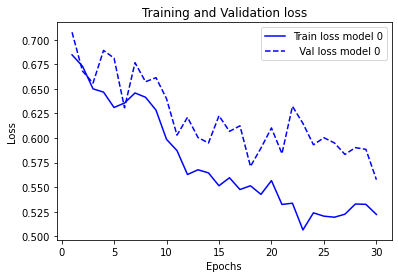

In [ ]:
plotFineTunedGraph(total_train_history, total_val_history, lr_toTune=lr_toTune)

In [ ]:
best_model_num = np.argmax(lowest_loss)
Best_siameseNet = customize_SiameseNetwork()
Best_siameseNet.load_state_dict(weights[best_model_num]) #load best trained weight

# continue training

In [ ]:
#continue training
lr_toTune=[0.001]
epochs=70
lowest_loss2, weights2, total_train_history2, total_val_history2 = finetune(Best_siameseNet, resNet, trainloader, valloader, lr_toTune=lr_toTune, num_epochs=epochs)

.................................................................out: tensor([0.3185, 0.4511], device='cuda:0')   labels: tensor([0., 0.], device='cuda:0')Model 0 (lr=0.001), Epoch  1/70 : train_loss = 0.5368, val_loss = 0.6096
.................................................................out: tensor([0.7050, 0.4408], device='cuda:0')   labels: tensor([1., 1.], device='cuda:0')Model 0 (lr=0.001), Epoch  2/70 : train_loss = 0.5344, val_loss = 0.5911
.................................................................out: tensor([0.2481, 0.4442], device='cuda:0')   labels: tensor([0., 0.], device='cuda:0')Model 0 (lr=0.001), Epoch  3/70 : train_loss = 0.5335, val_loss = 0.5681
.................................................................out: tensor([0.7666, 0.7385], device='cuda:0')   labels: tensor([0., 0.], device='cuda:0')Model 0 (lr=0.001), Epoch  4/70 : train_loss = 0.5257, val_loss = 0.5620
.................................................................out: tensor([0.8136, 0.

In [ ]:
print("lowest val loss", lowest_loss2)

lowest val loss [0.542828234202332]


Model 0 (lr=0.001)


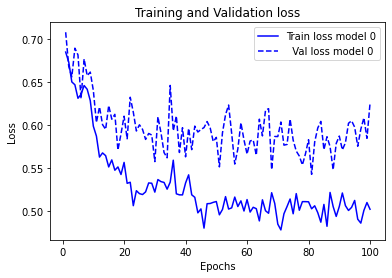

In [ ]:
total_val_history_2nd = np.expand_dims((total_val_history[0] + total_val_history2[0]), axis=0)
total_train_history_2nd = np.expand_dims((total_train_history[0] + total_train_history2[0]), axis=0)  
plotFineTunedGraph(total_train_history_2nd, total_val_history_2nd, lr_toTune=lr_toTune)

observation: no further improvement

In [ ]:
best_model_num2 = np.argmax(lowest_loss2)
Best_siameseNet2 = customize_SiameseNetwork()
Best_siameseNet2.load_state_dict(weights2[best_model_num2]) #load best trained weight
torch.save(Best_siameseNet2, "saved_best_siameseNet.pt") #save whole model

---
# Test model

In [ ]:
# transformer
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = FaceDataset("./dataset/test", transform=test_transform)
testloader = DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
#load model
my_resNet = torch.load("saved_best_resNet34.pt") 
siameseNet = torch.load("saved_best_siameseNet.pt")

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
Best_siameseNet = Best_siameseNet.to(device)
siameseNet.eval()
resNet = resNet.to(device)
resNet.eval()

running_corrects = 0.
running_count = 0.
for i, (img1, img2, labels) in enumerate(testloader):  #batch iteration
    # transfer data to device available
    img1 = img1.to(device)
    img2 = img2.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        # feature extraction by backbone network
        x1 = resNet(img1) #get feature vector for image 1 (128 D)
        x2 = resNet(img2) #get feature vector for image 2 (128 D)

        # forward propagation Siamese network to get output
        outs = Best_siameseNet(x1, x2)
        outs = outs.reshape(-1)
        outs = outs.cpu()
        labels = labels.to(torch.float32)
        predicted = np.where(outs<0.5, 0, 1)
        predicted = torch.tensor(predicted)
        predicted = predicted.cuda()
        running_corrects += (predicted == labels).sum().double()
        running_count += len(labels)
        print('.', end='')

print('\nAccuracy = {:.2f}%'.format(100*running_corrects/running_count))
print("running_corrects", running_corrects)
print("running_count", running_count)

......................................................................................................................................................................................................................................................
Accuracy = 71.97%
running_corrects tensor(706., device='cuda:0', dtype=torch.float64)
running_count 981.0
